## Product Detection Training Model

In [1]:
# !pip uninstall tensorflow-gpu -y
# !pip uninstall tensorflow -y
# !pip install tensorflow-gpu==2.0.0-rc0

Check availability of GPU

In [2]:
# %tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Import standard libraries including Pre-Trained Model

In [3]:
import tensorflow as tf
from tensorflow import keras
from keras import preprocessing
from keras.models import model_from_json
from keras_preprocessing.image import load_img
from keras_preprocessing.image import img_to_array
from keras.applications.resnet_v2 import preprocess_input
# from keras.applications.resnet_v2 import decode_predictions
from keras.applications import ResNet50V2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Setting up TPU (TBC)

In [4]:
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)

# # instantiate a distribution strategy
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

In [5]:
# filenames = tf.io.gfile.glob("../input/shopee-product-detection-student/train/train/train")
# dataset = tf.data.TFRecordDataset(filenames)
# # dataset = dataset.map(...) # TFRecord decoding here...
# dataset

## Generate Image with Different Image Augmentations

Apply CutOut Method

In [6]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return preprocess_input(input_img)

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return preprocess_input(input_img)

    return eraser

In [7]:
data_generator = preprocessing.image.ImageDataGenerator( 
    rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
#     shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,
    fill_mode="nearest",
#     cval=0.0,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=get_random_eraser(v_l=0, v_h=255)
)
#     preprocessing_function=get_random_eraser(v_l=0, v_h=255)

## Load Training & Validation Image Generator

In [8]:
train_datagen =  data_generator.flow_from_directory(
        '../input/shopee-product-detection-student/train/train/train',
        class_mode="categorical",
        color_mode="rgb",
        batch_size=128,
        target_size=(256, 256),
        shuffle=True,
        subset="training",
        interpolation="bilinear")

Found 79058 images belonging to 42 classes.


In [9]:
validation_datagen =  data_generator.flow_from_directory(
        '../input/shopee-product-detection-student/train/train/train',
        class_mode="categorical",
        color_mode="rgb",
        batch_size=128,
        target_size=(256, 256),
        shuffle=False,
        subset="validation",
        interpolation="bilinear")

Found 26332 images belonging to 42 classes.


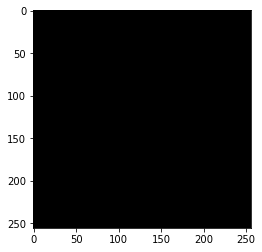

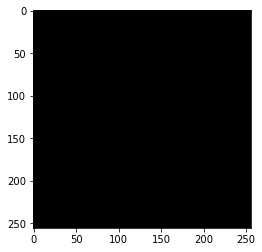

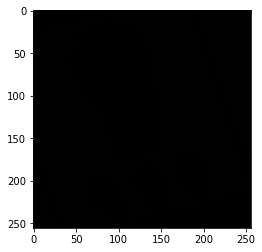

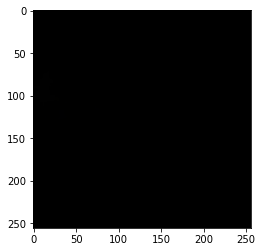

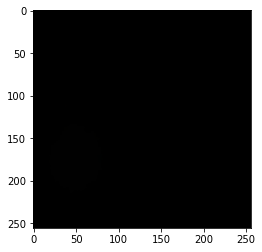

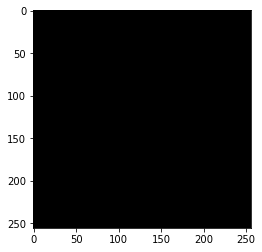

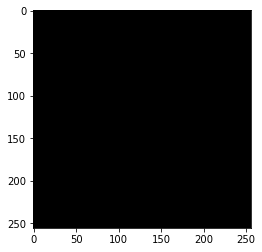

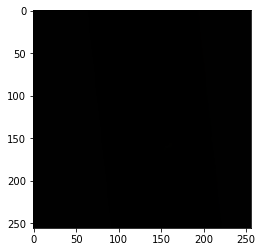

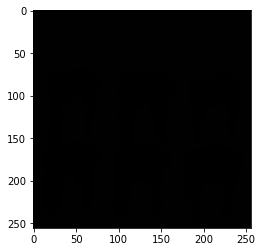

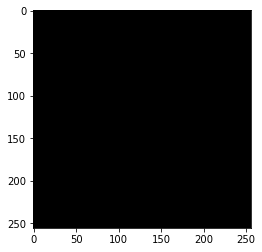

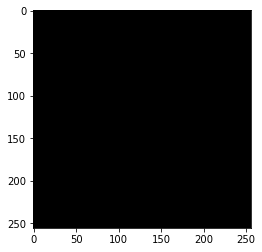

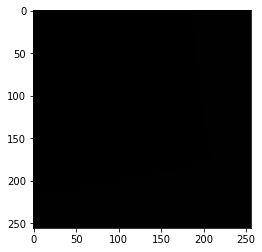

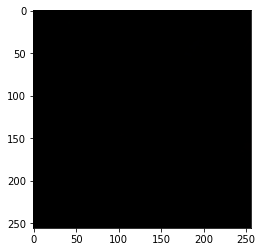

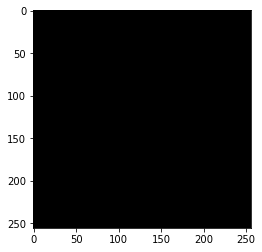

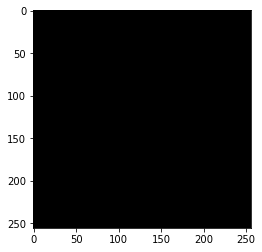

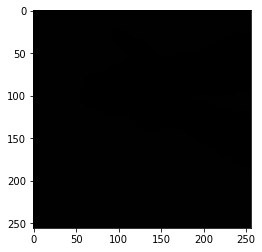

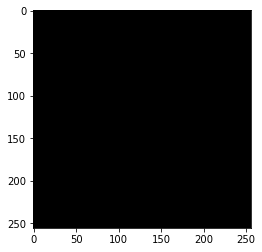

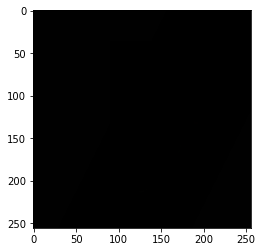

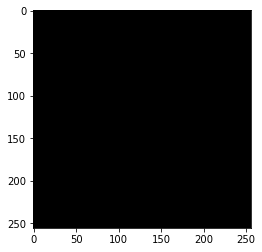

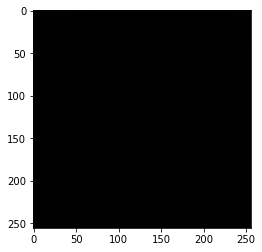

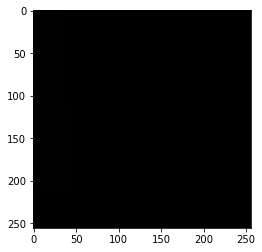

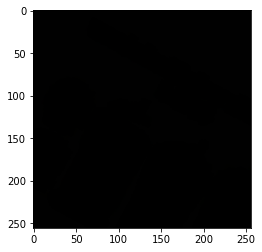

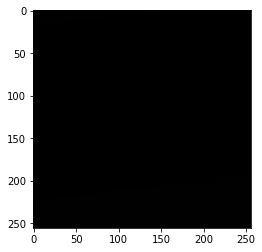

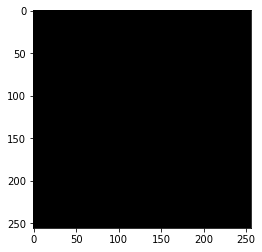

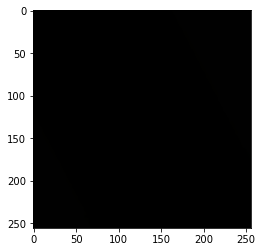

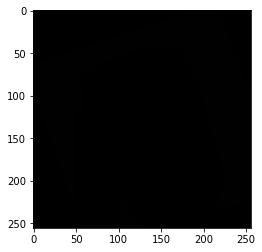

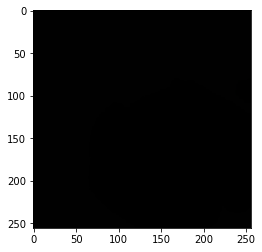

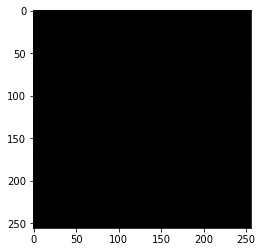

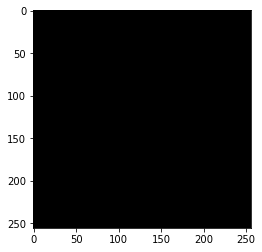

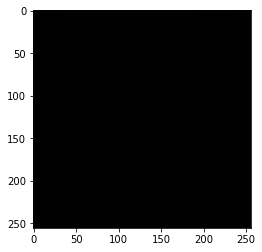

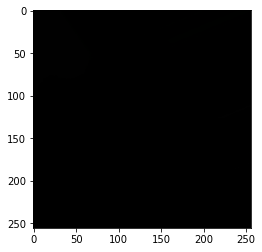

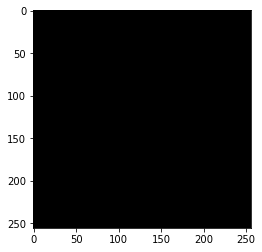

In [10]:
# x= np.array(train_datagen[0])
# # x = x.reshape((1,) + x.shape)
x_batch, y_batch = next(train_datagen)
for i in range (0,32):
    image = x_batch[i]
    plt.imshow(image)
    plt.show()

## Link Pre-Trained Model with Custom Neural Network

In [11]:
# from keras.models import Model
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import Dropout
# from keras.layers import GlobalAveragePooling2D
# from keras import Sequential
# from keras.optimizers import SGD

# #load the model without classifier layers

# model_1 = ResNet50V2(
#     include_top=False,
#     weights="imagenet",
#     input_shape=(256,256,3),
# )

# #add new classifier layer
# model = Sequential()
# model.add(model_1)
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(42, activation='softmax'))
# # class1 = Dense(1024, activation='relu')(flat1)
# # output = Dense(10, activation='softmax')(class1)
# #Define the model
# # model = Model(inputs=model.inputs, outputs = output)
# #Compile mode
# # opt = SGD(lr=0.01, momentum=0.9)

# # model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
# # #Summarize
# model.summary()

## Load Updated Training Model

In [12]:
# Load Latest Model
# load json and create model
json_file = open('../input/shopeeproductmodel/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("../input/shopeeproductmodel/model.h5")
print("Loaded model from disk")
model=loaded_model
model.summary()

Loaded model from disk
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 8, 8, 2048)        23564800  
_________________________________________________________________
flatten_3 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              134218752 
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 42)                43050     
Total params: 157,826,602
Trainable params: 157,781,162
Non-trainable params: 45,440
_________________________________________________________________


## Compile model with different configurations (Optimizer & Loss, Learning Rate)

In [13]:
batch_size = 128
epochs_num = 5
INIT_LR = 0.0020

> Included learning function

In [14]:
# Learning Function
class PolynomialDecay():
    def __init__(self, maxEpochs=100, initAlpha=0.01, power=1.0):
    # store the maximum number of epochs, base learning rate,
    # and power of the polynomial
        self.maxEpochs = maxEpochs
        self.initAlpha = initAlpha
        self.power = power
    def __call__(self, epoch):
        # compute the new learning rate based on polynomial decay
        decay = (1 - (epoch / float(self.maxEpochs))) ** self.power
        alpha = self.initAlpha * decay
        # return the new learning rate
        return float(alpha)

> Added multiple callbacks and label_smoothing

In [15]:
# import os
# model_path = '../model/'
# if not os.path.exists(model_path):
#     os.mkdir(model_path)
    


In [16]:
from keras.optimizers import SGD
# from tf.keras.callbacks import callback
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping, ModelCheckpoint
# from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
# from tensorflow.keras.callbacks import TensorBoard


# Include Checkpoint Callback
# checkpoint_filepath = 'training_weight.{epoch:02d}-{val_loss:.2f}.ckpt'
checkpoint_filepath = 'best_model.hdf5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_best_only=True,
    monitor='val_loss',
    mode='min')
#     save_weights_only=True,
# # Load TensorBoard
# tensor_board_callback = TensorBoard(
#     log_dir="./logs",
#     update_freq="batch")

# Use Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, mode='min', verbose=1),

# Load Different Configurations
opt = SGD(lr=INIT_LR, momentum=0.9)
loss = CategoricalCrossentropy(label_smoothing=0.1)
schedule = PolynomialDecay(maxEpochs=epochs_num, initAlpha=INIT_LR,power=1.0)

callbacks = [LearningRateScheduler(schedule),model_checkpoint_callback,early_stopping]

model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])

## Train Model with Different Epochs and Batch Size

In [17]:
history = model.fit_generator(
    train_datagen,
    epochs=epochs_num,
    steps_per_epoch=np.ceil(train_datagen.samples // batch_size),
    validation_data = validation_datagen,
    validation_steps = np.ceil(validation_datagen.samples // batch_size),
    callbacks = callbacks,
    use_multiprocessing=True,
    workers=2
)

Epoch 1/5
617/617 [==============================] - 3625s 6s/step - loss: 1.1394 - accuracy: 0.8666 - val_loss: 1.5128 - val_accuracy: 0.7461 - lr: 0.0020
Epoch 2/5
617/617 [==============================] - 3649s 6s/step - loss: 1.1171 - accuracy: 0.8740 - val_loss: 1.5126 - val_accuracy: 0.7470 - lr: 0.0016
Epoch 3/5
617/617 [==============================] - 3807s 6s/step - loss: 1.1049 - accuracy: 0.8789 - val_loss: 1.4956 - val_accuracy: 0.7502 - lr: 0.0012
Epoch 4/5
617/617 [==============================] - 3906s 6s/step - loss: 1.0906 - accuracy: 0.8851 - val_loss: 1.4977 - val_accuracy: 0.7529 - lr: 8.0000e-04
Epoch 5/5
617/617 [==============================] - 3834s 6s/step - loss: 1.0848 - accuracy: 0.8871 - val_loss: 1.4891 - val_accuracy: 0.7530 - lr: 4.0000e-04


## Visualization of Training Outcome

In [18]:
# %load_ext tensorboard
# %tensorboard --logdir logs/train

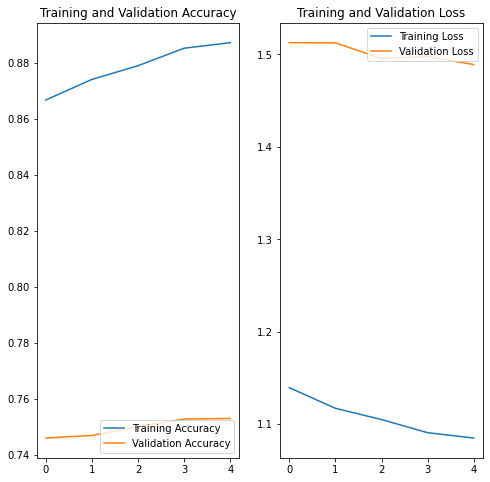

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs_num)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Save Model for next training

In [20]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


## Test Prediction

In [21]:
# # load an image from file
# image = load_img('../input/shopee-product-detection-student/train/train/train/24/000799b8263de13f2db497f9d21e9f13.jpg', target_size=(256, 256))
# # convert the image pixels to a numpy array
# image = img_to_array(image)
# # reshape data for the model
# image = image.reshape((1,256,256,3))
# # prepare the image for the VGG model
# image = preprocess_input(image)

In [22]:
# yhat = model.predict(image)
# yhat

In [23]:
# print(np.argmax(yhat))

In [24]:
# model.evaluate_generator(validation_datagen, steps=np.ceil(validation_datagen.samples // batch_size),verbose=2)